# Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import matplotlib.cm as cm

from network import Net
from diff_equation import *

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

np.random.seed(10)

# Training and Test Data

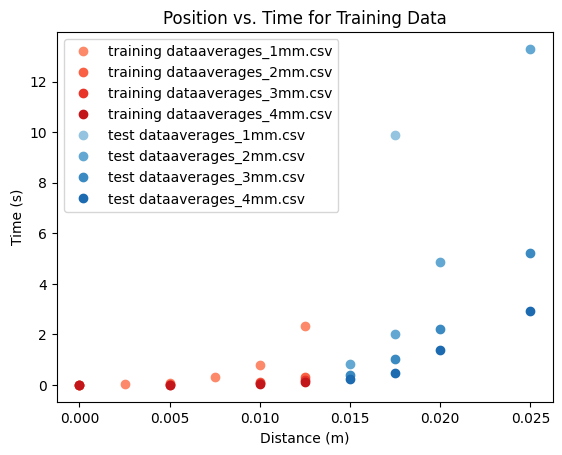

In [2]:
# Generate color gradients
num_curves = len(train)
red_colors = [cm.Reds(0.4 + 0.5 * (i / num_curves)) for i in range(num_curves)]
blue_colors = [cm.Blues(0.4 + 0.5 * (i / num_curves)) for i in range(num_curves)]

# Plot training data with progressively darker red
for i in range(num_curves):
    plt.plot(train[i]['DISTANCE'], train[i]['TIME'], 'o', color=red_colors[i])

# Plot test data with progressively darker blue
for i in range(num_curves):
    plt.plot(test[i]['DISTANCE'], test[i]['TIME'], 'o', color=blue_colors[i])

plt.ylabel('Time (s)')
plt.xlabel('Distance (m)')
plt.title('Position vs. Time for Training Data')

# Adjust legend generation if legend is defined
plt.legend(np.concatenate((['training data' + item for item in legend], 
                           ['test data' + item for item in legend])))
plt.show()

# Run the Model

Losses for 1mm droplet:


c:\Users\rahav\Documents\GitHub\pinns-model\.venv\Lib\site-packages\torch\autograd\graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/30000, data loss: 1.1034774780273438, physics loss: 985670.5625
Epoch 2/30000, data loss: 1.0997161865234375, physics loss: 985658.0625
Epoch 3/30000, data loss: 1.0959529876708984, physics loss: 985645.5625
Epoch 4/30000, data loss: 1.0919018983840942, physics loss: 985632.0
Epoch 5/30000, data loss: 1.0874042510986328, physics loss: 985616.625
Epoch 6/30000, data loss: 1.0823509693145752, physics loss: 985598.75
Epoch 7/30000, data loss: 1.076636552810669, physics loss: 985578.0625
Epoch 8/30000, data loss: 1.0701359510421753, physics loss: 985553.4375
Epoch 9/30000, data loss: 1.0626953840255737, physics loss: 985524.1875
Epoch 10/30000, data loss: 1.0541480779647827, physics loss: 985489.5625
Epoch 3000/30000, data loss: 14.354072570800781, physics loss: 10283.908203125
Epoch 6000/30000, data loss: 0.14734168350696564, physics loss: 5178.62744140625
Epoch 9000/30000, data loss: 0.02455781027674675, physics loss: 3257.895751953125
Epoch 12000/30000, data loss: 0.039473816752

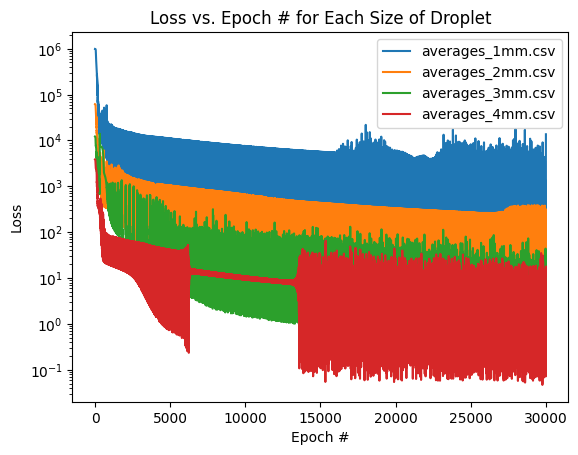

In [3]:
num_epochs = 30000
data_loss_weight = 1
physics_loss_weight = 1
lr = 8*1e-4
batch_size = 8

'''
Train model for each droplet size, plot losses for each one.
Change the bounds on this loop and subsequent ones from '0', 'len(different_droplet_networks)' to '0', '1' to do only the 1mm droplet.
You can change the bounds similarly to only train the network for other-sized droplets.
'''
plt.yscale('log')
different_droplet_networks = [None] * len(train)

for i in range(0, len(different_droplet_networks)):
    different_droplet_networks[i] = Net(1, 1, droplet_size_idx=i, loss2=physics_loss_dim, epochs=num_epochs, loss1_weight=data_loss_weight, loss2_weight=physics_loss_weight, lr=lr, batch_size=batch_size).to(DEVICE)
    print(f'Losses for {i+1}mm droplet:')
    data_losses, physics_loss, tot_losses = different_droplet_networks[i].fit(np.array(train[i]['DISTANCE']), np.array(train[i]['TIME']))
    print()
    plt.plot(tot_losses)
plt.legend(legend)
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch # for Each Size of Droplet')
plt.show()

# Plot the Results

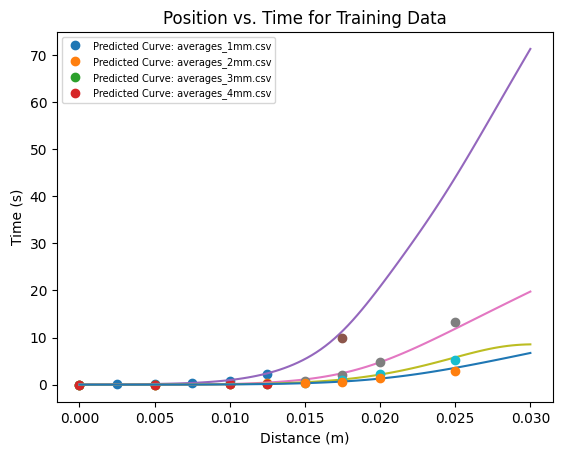

In [4]:
'''
Plot the data for each droplet as well as each respective dimensionalized model
'''

# Plot training data
for i in range(0, len(different_droplet_networks)):
    plt.plot(train[i]['DISTANCE'], train[i]['TIME'], 'o')
plt.legend(legend)
plt.ylabel('Time (s)')
plt.xlabel('Distance (m)')
plt.title('Position vs. Time for Training Data')

# Use model to make prediction
xs = np.linspace(0, 0.03, 100)

predicted_curves_legend = ['Predicted Curve: ' + item for item in legend]

# Plot model prediction curves
for i in range(0, len(different_droplet_networks)):
    preds = different_droplet_networks[i].predict(xs)
    plt.plot(xs, preds)
    plt.plot(test[i]['DISTANCE'], test[i]['TIME'], 'o')
plt.legend(predicted_curves_legend, fontsize=7)
plt.show()

# MSE Calculation

In [6]:
'''
Calculate MSE over test data
'''

MSE = np.zeros(len(test))

for i in range(0, len(different_droplet_networks)):
    for j in range(0, len(test[i])):
        # get actual value
        actual = test[i]['TIME'][j]

        # get predicted value
        value = test[i]['DISTANCE'][j]
        input_array = np.array([[value]])
        pred = different_droplet_networks[i].predict(input_array)[0]
        MSE[i] += np.pow(actual - pred, 2)
    print(f"MSE for {legend[i]}: {MSE[i]}")

MSE for averages_1mm.csv: 2.2620384214422775
MSE for averages_2mm.csv: 2.3060190201667834
MSE for averages_3mm.csv: 0.3583906572132299
MSE for averages_4mm.csv: 0.4403492869394298


C:\Users\rahav\AppData\Local\Temp\ipykernel_21756\4137129022.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  MSE[i] += np.pow(actual - pred, 2)
